# 📖 A Journey to Optimize the Supply Chain for Just In Time
**Analyst: Itunuoluwa Olowoye**

At Just In Time, in the heart of our bustling commerce, our mission here today is simple. We are identifying shipment and inventory challenges, uncovering insights and creating dashboards for actionable solutions.<br>
Imagine busy warehouses loaded with products, and stores processing and delivering customer orders. We will dive into the data, spot potential delays and improve operations. The data is contained in `.csv` files in the `data/` folder provided.

What is the outcome? User-friendly dashboards with a clear supply chain story from shipment processing to inventory management, and the economic and behavioural concepts that govern them for a more efficient future.<br><br>
![](data/shipments.jpg)

## Data Preparation
Three datasets were provided: Orders and Shipments, Inventory, and Warehouse Fulfillment.

In [52]:
# import modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import warnings
warnings.filterwarnings('ignore')

### Data Cleaning

In [53]:
# define a function to load and clean the data
def load_data(file, date_sets={}):
    
    df = pd.read_csv(file, skipinitialspace=True) # read file
    df.columns = df.columns.str.strip() # remove whitespace from column headers
    # create date column in correct format; write set of columns corresponding to a complete date in a dictionary;
    # for each set of columns corresponding to a complete date
    for set in date_sets.keys():
        value = date_sets[set] # store the column names in a variable in year, month, day, time format
        try:
            # extract year, month and day
            year= value.split(',')[0].strip(); month= value.split(',')[1].strip(); day= value.split(',')[2].strip()
            # join year, month and day columns together in YYYYMMDD format
            df[set + ' Date'] = df[year].astype(str) + df[month].astype(str).str.zfill(2) + df[day].astype(str).str.zfill(2)
            df.drop(value.split(', '), axis=1, inplace=True) # drop individual date columns from the dataframe
            df[set + ' Date'] = pd.to_datetime(df[set + ' Date'], format='%Y%m%d') # convert new date column to datetime
        except IndexError:
            df[set + ' Date'] = pd.to_datetime(df[value], format='%Y%m') # convert existing column to datetime
        except Exception as error:
            print(error) # print error encountered
    for col in df.columns: # for each column in the dataframe
        if df[col].dtype=='object': # if datatype is string
            df[col] = df[col].str.replace('  ',' ').str.strip() # remove whitespace from column values

    return df

In [54]:
# load and clean files as needed
orders_shipments = load_data('data/orders_and_shipments.csv',
                             date_sets={'Order': 'Order Year, Order Month, Order Day, Order Time',
                                        'Shipment': 'Shipment Year, Shipment Month, Shipment Day'})

inventory = load_data('data/inventory.csv', date_sets={'Inventory':'Year Month'})

warehouse = load_data('data/fulfillment.csv')

In [55]:
# inspect data
display(orders_shipments.head(1))
display(inventory.head(1))
display(warehouse.head(1))

,Order ID,Order Item ID,Order YearMonth,Order Quantity,Product Department,Product Category,Product Name,Customer ID,Customer Market,Customer Region,Customer Country,Warehouse Country,Shipment Mode,Shipment Days - Scheduled,Gross Sales,Discount %,Profit,Order Date,Shipment Date
0,3535,8793,201502,1,Fan Shop,Fishing,Field & Stream Sportsman 16 Gun Fire Safe,7840,LATAM,Central America,Mexico,Puerto Rico,Standard Class,4,400,0.25,200,2015-02-21,2015-02-27


,Product Name,Year Month,Warehouse Inventory,Inventory Cost Per Unit,Inventory Date
0,Perfect Fitness Perfect Rip Deck,201712,0,0.69517,2017-12-01


,Product Name,Warehouse Order Fulfillment (days)
0,Perfect Fitness Perfect Rip Deck,8.3


In [56]:
# save prepared dataframes
orders_shipments.to_csv('data/orders_and_shipments_prepped.csv', index=False)
inventory.to_csv('data/inventory_prepped.csv', index=False)
warehouse.to_csv('data/fulfillment_prepped.csv', index=False)

### Creating Recency, Frequency, and Monetary Value (RFM) Data for Customer Behaviour Segmentation

In [57]:
# group by customer id and calculate last order date and number of unique orders placed by each customer
rf_df = orders_shipments.groupby('Customer ID').agg(Recency = ('Order Date', 'max'),
                                                    Frequency = ('Order ID', 'nunique'))

In [58]:
# store max date of orders table in a variable
max_date = orders_shipments['Order Date'].max()
# calculate recency for each customer
rf_df['Recency'] = (max_date - rf_df['Recency']).dt.days

In [59]:
# calculate average sales generated by each customer
# the orders are split by order items so we add all sales in each customer order first 
# then calculate the average sales of orders for each customer
m_df = orders_shipments.groupby(['Customer ID','Order ID']).sum().reset_index()\
    .groupby('Customer ID').agg(MonetaryValue = ('Gross Sales', 'mean'))

In [60]:
# create rfm dataset
df_rfm = pd.concat([rf_df, m_df], axis=1)

In [61]:
# create a copy
rfm_raw = df_rfm.copy()

In [62]:
# check for skewness, and perform log/cubic transformation if the data is skewed
for col in df_rfm:
    skew = df_rfm[col].skew() # calculate skew
    if (skew <= -1) or (skew >= 1): # if skew is not within -1 to 1
        transform = np.log(df_rfm[col]) # transform to log scale
        if transform.min() == float('-inf') or transform.max() == float('inf'): # if log transformation includes infinity values
            transform = np.cbrt(df_rfm[col]) # transform to cubic scale instead
            message = f'Cubic transformation on {col}'
        else: message = f'Log transformation on {col}'
        print(message)
        df_rfm[col] = transform

Log transformation on Frequency


In [63]:
# initialize a standard scaler to standardize data
scaler = StandardScaler()

In [64]:
# standardize df
scaler.fit(df_rfm)
df_rfm_norm = scaler.transform(df_rfm)
df_rfm_norm = pd.DataFrame(df_rfm_norm, index=df_rfm.index, columns=df_rfm.columns)

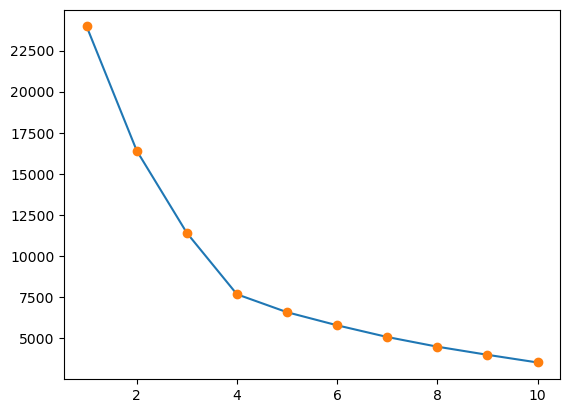

In [65]:
# find optimum number of clusters
sse= []
for k in range(1,11):
    kmeans= KMeans(n_clusters=k,n_init= 10,max_iter=300,tol=0.0001)
    a= kmeans.fit(df_rfm_norm)
    sse.append(a.inertia_)
plt.plot(range(1,11),sse,'-');
plt.plot(range(1,11),sse,'o');

In [72]:
# create clusters
kmeans= KMeans(n_clusters=6, random_state=42)
kmeans.fit(df_rfm_norm)
cluster_labels = list(kmeans.labels_)

In [73]:
# assign clusters to raw data
rfm_raw = rfm_raw.assign(Cluster = cluster_labels)

In [74]:
# define a function to change cluster numbers to alphabets
def number_to_alphabet(number):
    if 0 <= number <= 25: return chr(number + 97).upper()
    else: return None

In [75]:
# change numbers to alphabets
rfm_raw['Segment'] = rfm_raw['Cluster'].apply(number_to_alphabet)

In [76]:
# inspect dataframe
rfm_raw.head(1)

,Recency,Frequency,MonetaryValue,Cluster,Segment
Customer ID,,,,,
2,237,3,573.333333,3,D


In [77]:
# save data
rfm_raw.to_csv('data/customer_segments.csv')

### Creating Association Data For Market Basket Analysis

In [47]:
# create a function to change numbers to binary
def encoding(x, num=0):
    if x<=num: return False
    else: return True

In [48]:
# separate the orders/shipment data based on customer country
countries_dfs = {} # create an empty dictionary to store data
for country in orders_shipments['Customer Country'].unique(): # for every unique country
    df = orders_shipments[orders_shipments['Customer Country']==country] # filter data to data for that country
    countries_dfs[country] = df # store data as a key value pair in dictionary

In [49]:
# create dataframe of market basket association rules
rules_df = pd.DataFrame() # create an empty dataframe
for country in countries_dfs.keys(): # for each country's data
    df = countries_dfs[country] # store data in variable
    market_basket = df.groupby(['Order ID','Product Name']).size().to_frame('count').unstack().fillna(0) # create market basket
    market_basket.columns = market_basket.columns.droplevel() # remove multi-level column
    market_basket = market_basket.applymap(encoding) # convert from numbers to binary
    frequent_items = apriori(market_basket, min_support=0.01, use_colnames=True) # find frequent items
    rules = association_rules(frequent_items, metric='lift') # create association rules
    rules = rules.explode('antecedents').explode('consequents') # split associations into separate rows
    rules = rules.groupby(['antecedents','consequents']).mean(numeric_only=True).reset_index() # group by antecedent-consequent pairs
    rules.rename(columns={'antecedents':'Product','consequents':'Associated Product','confidence':'Confidence'}, inplace=True) # rename columns
    rules['Customer Country'] = country # create country column
    if rules.empty is False: rules = rules.loc[:,['Product','Associated Product','Confidence','Customer Country']]
    rules_df = pd.concat([rules_df, rules], axis=0) # store market basket in dataframe

In [50]:
# inspect dataframe
rules_df.head(1)

,Product,Associated Product,Confidence,Customer Country
0,Diamondback Women's Serene Classic Comfort Bi,Field & Stream Sportsman 16 Gun Fire Safe,0.122474,Mexico


In [51]:
# save data
rules_df.to_csv('data/market_baskets.csv',index=False)

## 🧾 Executive Summary

Our in-depth analysis of Just In Time's supply chain operations have shown us valuable insights that cab help to drive significant improvements.
### Methodology
We loaded and cleaned all datasets provided namely Orders and Shipments, Inventory, and Warehouse fulfilment. We conducted a first phase of transformation to prepare additional data for customer behavioural segmentation, and market basket analysis. We then loaded them all into PowerBI and transformed them from raw data into insights using Power Queries and DAX expressions.
### Key Findings and Their Implications
The data provided was from 2015 to 2017.
1. Shipments:<br>There are recurring delays in processing shipments which could be responsible for the downturn in customer retention and purchase frequency. Almost half (~44%) of all order items were shipped late. In fact there was a general upward trend in the number of days shipments were delayed - a whooping increase from as low as a 2-day delay to as high as a 60-day delay. Would you want to wait two months to receive your order?<br>Also, the higher-end shipping modes were very inefficient. Majority of the order items shipped as First Class or Second Class arrived late. Customers would not be happy paying extra for shipping and getting poor delivery service.<br>

2. Inventory Stock Levels:<br>Almost 71k products were supplied. $81k was spent on inventory and up to $22k of that could have been saved if stock levels were more balanced. Supply levels fluctuated wildly and were never quite on par with demand. Understanding the demand trends for each product will help to optimize stock levels, reduce carrying costs and can potentially reduce shipment delays that may be caused by understock.<br>

3. Warehousing:<br>Both warehouses were involved in shipping order items. Certain products have demand and high warehouse restock time. Stock levels of these products need to be more closely monitored to ensure that supply and demand levels are close.<br>

4. Demand and Profitability:<br>The top three demanded products were <br>
    * Perfect Fitness Perfect Rip Deck (70% likely associated, on average with Bag Boy Beverage Holder), 
    * Nike Men's DriFIT Victory Golf Polo (71% likely associated, on average with Nike Women's Legend Tshirt), and 
    * O'Brien Men's Neoprene Life Vest (78% likely associated, on average with Titleist Pro V1 High Numbers Personalized Gol) respectively.<br>

    The top three products with high profit margin were <br>
    * Nike Men's Comfort 2 Slides (92% likely associated, on average with Nike Men's CJ Elite 2 TD Football Cleat), 
    * Hirzl Women's Soft Flex Golf Gloves (96% likely associated, on average with O'Brien Men's Neoprene Life Vest), and 
    * O'Brien Men's Neoprene Life Vest (*already mentioned*) respectively.<br>

    In general, the Fan Shop department had the highest demand, sales, and profit of 18k, $2.93m, and $1.64m respectively, followed by the Golf and Apparel departments. In terms of profit margins, the Footwear department also shines.<br>Most orders come from the USA but Brazil also has a fair amount of demand.<br>

5. Customer base:<br>There are almost 8000 customers in total and most of them come from the USA. Customer retention and purchase frequency is very poor and this could be due to above-mentioned inefficiencies in inventory and shipment. The RFM analysis identifies six segments of customers and while the absolute values of recency and frequency are not encouraging in all segments, customers in segments C and D are potentially retainable after customer delivery challenges have been solved.<br>
### Conclusion and Recommendation
Despite the challenges, Just In Time have managed to run on a profit. However, towards the end of 2017, order demand, sales and profit hit a low and we can do so much better. There are some recommendations if we are to bounce back at Just In Time. First, we need to address the general shipment delays and find the root cause of why delays can be as high as two months and solve it. Second, we need to provide better services for higher-end shipping modes. Third, we need to adopt demand forecasting methods and regular stock audits to ensure that we are at optimum stock level, as much as possible. Fourth, we can take advantage of closely associated products to understand demand trends. Finally, in the event that warehouses are needed in other continents, Brazil can be a good option for its fair number of customers and closeness to other countries who have not so great shipment times.

## 📷 Dashboard screenshot
![](data\dashboard_page.jpg)